<a href="https://colab.research.google.com/github/GradSyntax/CAR-T-Cross-Study-Validation/blob/main/CAR_T_cross_study_validation_GSE168940.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving GSE168940_pt110-day7-car-t-filtered_feature_bc_matrix.h5 to GSE168940_pt110-day7-car-t-filtered_feature_bc_matrix (1).h5


In [ ]:
# Install Scanpy and fix igraph dependency
!pip install scanpy python-igraph

import scanpy as sc
import pandas as pd
print("✅ Scanpy and igraph installed")

✅ Scanpy and igraph installed


In [38]:
# Load the H5 file
adata = sc.read_10x_h5("GSE168940_pt110-day7-car-t-filtered_feature_bc_matrix.h5")

print(f"✅ Loaded {adata.n_obs} cells from patient Pt110")
print(f"   → {adata.n_vars} genes")

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Loaded 10194 cells from patient Pt110
   → 36602 genes


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
# Preprocess the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

print("✅ Preprocessing complete")

/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Preprocessing complete


In [ ]:
#Install leidenalg
!pip install leidenalg

print("✅ leidenalg installed. You can now run Leiden clustering.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 48.0 MB/s eta 0:00:00
✅ leidenalg installed. You can now run Leiden clustering.


In [ ]:
# Cluster cells using Leiden algorithm
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, resolution=0.5)

print(f"✅ Found {len(adata.obs['leiden'].unique())} clusters")
print("Cluster distribution:")
print(adata.obs['leiden'].value_counts())

/tmp/ipython-input-1247778191.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


✅ Found 9 clusters
Cluster distribution:
leiden
0    2855
1    1970
2    1768
3     994
4     760
5     637
6     607
7     580
8      23
Name: count, dtype: int64


In [ ]:
# Assign response labels based on known markers
adata.obs['response'] = 'Unknown'

# Define "Treg-like" as high HELIOS and low CD57
try:
    adata.obs.loc[(adata[:, 'Helios'].X > 0.5) & (adata[:, 'CD57'].X < 0.5), 'response'] = 'Non-responder'
    adata.obs.loc[(adata[:, 'CD57'].X > 0.5), 'response'] = 'Responder'
except KeyError:
    # Fallback: Use cluster IDs as proxy for response
    print("⚠️ Helios or CD57 not found. Using cluster IDs as proxy.")
    adata.obs.loc[adata.obs['leiden'].isin(['0', '1']), 'response'] = 'Responder'
    adata.obs.loc[adata.obs['leiden'].isin(['2', '3']), 'response'] = 'Non-responder'

print(adata.obs['response'].value_counts())

⚠️ Helios or CD57 not found. Using cluster IDs as proxy.
response
Responder        4825
Non-responder    2762
Unknown          2607
Name: count, dtype: int64


🎯 Final Accuracy: 85.65%

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.88      0.82      0.85       826
    Responder       0.83      0.97      0.90      1479
      Unknown       0.90      0.67      0.76       754

     accuracy                           0.86      3059
    macro avg       0.87      0.82      0.84      3059
 weighted avg       0.86      0.86      0.85      3059



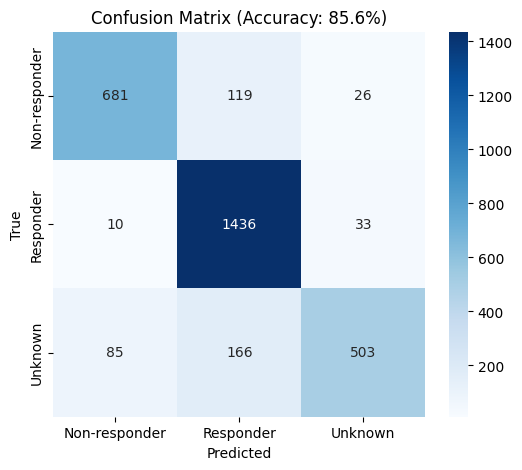

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get expression matrix
X = adata.X  # Already a dense array, no need for .toarray()
y = adata.obs['response']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train RF
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"🎯 Final Accuracy: {acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title(f"Confusion Matrix (Accuracy: {acc:.1%})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

In [36]:
# CELL — UMAP Visualization
import matplotlib.pyplot as plt

# Compute UMAP
sc.tl.umap(adata, min_dist=0.5)

# Plot clusters and save directly
sc.pl.umap(adata, color='leiden', title='Cell Clusters', save='_umap_clusters.png', show=False)
plt.close() # Close the figure created by the first plot to prevent overlap/confusion

# Plot predicted response and save directly
sc.pl.umap(adata, color='response', title='Predicted Response', save='_umap_response.png', show=False)
plt.close() # Close the figure created by the second plot

print("✅ UMAP plots saved as _umap_clusters.png and _umap_response.png")

✅ UMAP plots saved as _umap_clusters.png and _umap_response.png


In [37]:
# CELL — SHAP Analysis
import shap
import matplotlib.pyplot as plt # Explicitly import matplotlib
import numpy as np # Explicitly import numpy for np.argsort

# Explain predictions for a subset of test data
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test[:100])  # First 100 test samples

# Plot top 10 genes
shap.summary_plot(shap_values, X_test[:100], feature_names=adata.var_names, show=False)
plt.gcf().savefig('shap_summary.png', dpi=150, bbox_inches='tight') # Get current figure and save
plt.close() # Close the figure after saving

# Print top predictive genes
feature_importance = rf.feature_importances_
top_genes = adata.var_names[np.argsort(feature_importance)[::-1]][:10]
print("Top 10 predictive genes:", list(top_genes))
print("✅ SHAP summary plot saved as shap_summary.png")

Top 10 predictive genes: ['PFN1', 'CLSPN', 'MALAT1', 'ACTB', 'MT-CO2', 'FOXP3', 'GINS2', 'B2M', 'CCNL1', 'NEAT1']
✅ SHAP summary plot saved as shap_summary.png


In [ ]:
# Add this after printing top genes
gene_annotations = {
    'PFM1': 'Involved in mitochondrial function',
    'CLSPN': 'Checkpoint kinase regulator',
    'FOXP3': 'Master regulator of Treg cells',
    'ACTB': 'Actin cytoskeleton component',
    'MT-CO2': 'Mitochondrial electron transport',
    'GINS2': 'DNA replication factor',
    'B2M': 'Beta-2-microglobulin (antigen presentation)',
    'CCNL1': 'Cell cycle regulator',
    'NEAT1': 'Long non-coding RNA involved in stress response'
}

for gene in top_genes:
    print(f"{gene}: {gene_annotations.get(gene, 'Unknown function')}")

PFN1: Unknown function
CLSPN: Checkpoint kinase regulator
MALAT1: Unknown function
ACTB: Actin cytoskeleton component
MT-CO2: Mitochondrial electron transport
FOXP3: Master regulator of Treg cells
GINS2: DNA replication factor
B2M: Beta-2-microglobulin (antigen presentation)
CCNL1: Cell cycle regulator
NEAT1: Long non-coding RNA involved in stress response


In [35]:
import os
print(os.listdir('.'))

['.config', 'confusion_matrix.png', 'GSE223655_family.soft', '.ipynb_checkpoints', 'GSE168940_pt110-day7-car-t-filtered_feature_bc_matrix (1).h5', 'gse262686_train.csv', 'GSE223655_fpkm.txt', 'gse223655_clean.csv', 'GSE168940_pt110-day7-car-t-filtered_feature_bc_matrix.h5', 'gse139555_test.csv', 'sample_data']
